# SGAN

Utilizing a GAN as a 4th method of trajectory perturbation

## Setup

In [6]:
import warnings

warnings.filterwarnings('ignore', category=Warning)

In [7]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [35]:
import numpy as np
from pactus import Dataset
from pactus.models import LSTMModel
import matplotlib.pyplot as plt

from traj_xai.src import rdp_segmentation, mdl_segmentation, sliding_window_segmentation, gaussian_perturbation, rotation_perturbation, scaling_perturbation, gan_perturbation, TrajectoryManipulator

## Load Dataset

In [9]:
# Set a random seed for reproducibility
SEED = 0

# Load the dataset
# dataset = Dataset.uci_pen_digits()
# dataset = Dataset.uci_movement_libras()
# dataset = Dataset.mnist_stroke()
# dataset = Dataset.animals()
dataset = Dataset.geolife()
print(f"Dataset loaded: {len(dataset.trajs)} trajectories")

# Split data into train and test subsets
dataset = dataset.filter(lambda traj, _: len(traj) < 500)
train, test = dataset.split(0.8, random_state=SEED)
print(f"Train set: {len(train.trajs)} trajectories")
print(f"Test set: {len(test.trajs)} trajectories")

18:27:29 [INFO] Filtered 6474 of 9288 trajectories


Dataset loaded: 9288 trajectories
Train set: 5179 trajectories
Test set: 1295 trajectories


## Plot Sample Trajectory

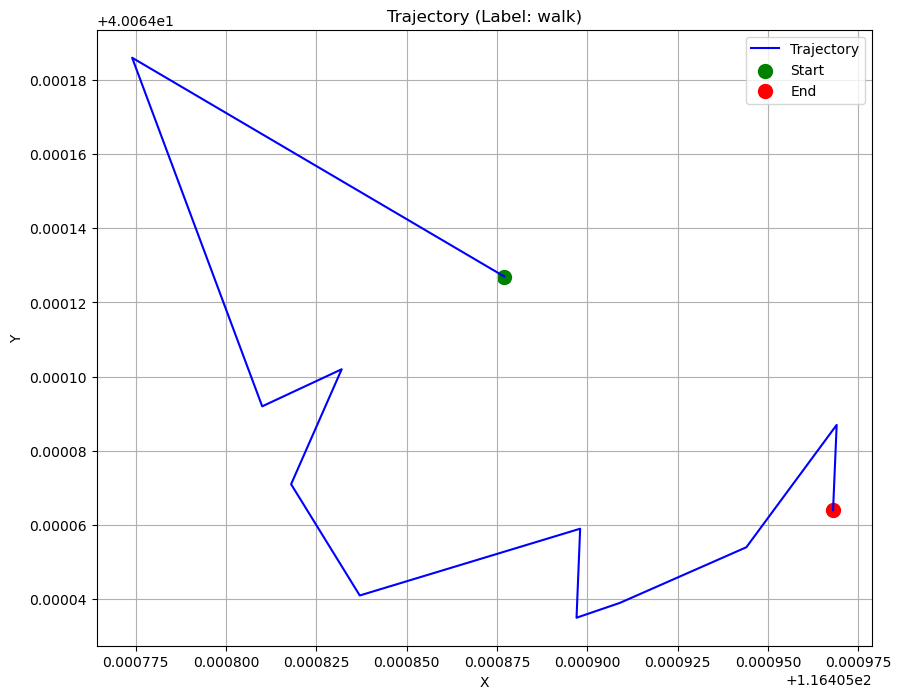

In [10]:
# Get a sample trajectory
sample_idx = 0
sample_traj = test.trajs[sample_idx]
sample_label = test.labels[sample_idx]

# Extract coordinates for plotting
points = sample_traj.r
x = [p[0] for p in points]
y = [p[1] for p in points]

# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(x, y, "b-", label="Trajectory")
plt.scatter(x[0], y[0], c="green", s=100, label="Start")
plt.scatter(x[-1], y[-1], c="red", s=100, label="End")
plt.title(f"Trajectory (Label: {sample_label})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Segment the Trajectory

Number of segments: 2
[[Vector([116.405877,  40.064127])], [Vector([116.405774,  40.064186]), Vector([116.40581 ,  40.064092]), Vector([116.405832,  40.064102]), Vector([116.405818,  40.064071]), Vector([116.405837,  40.064041]), Vector([116.405898,  40.064059]), Vector([116.405897,  40.064035]), Vector([116.405909,  40.064039]), Vector([116.405944,  40.064054]), Vector([116.405969,  40.064087]), Vector([116.405968,  40.064064])]]


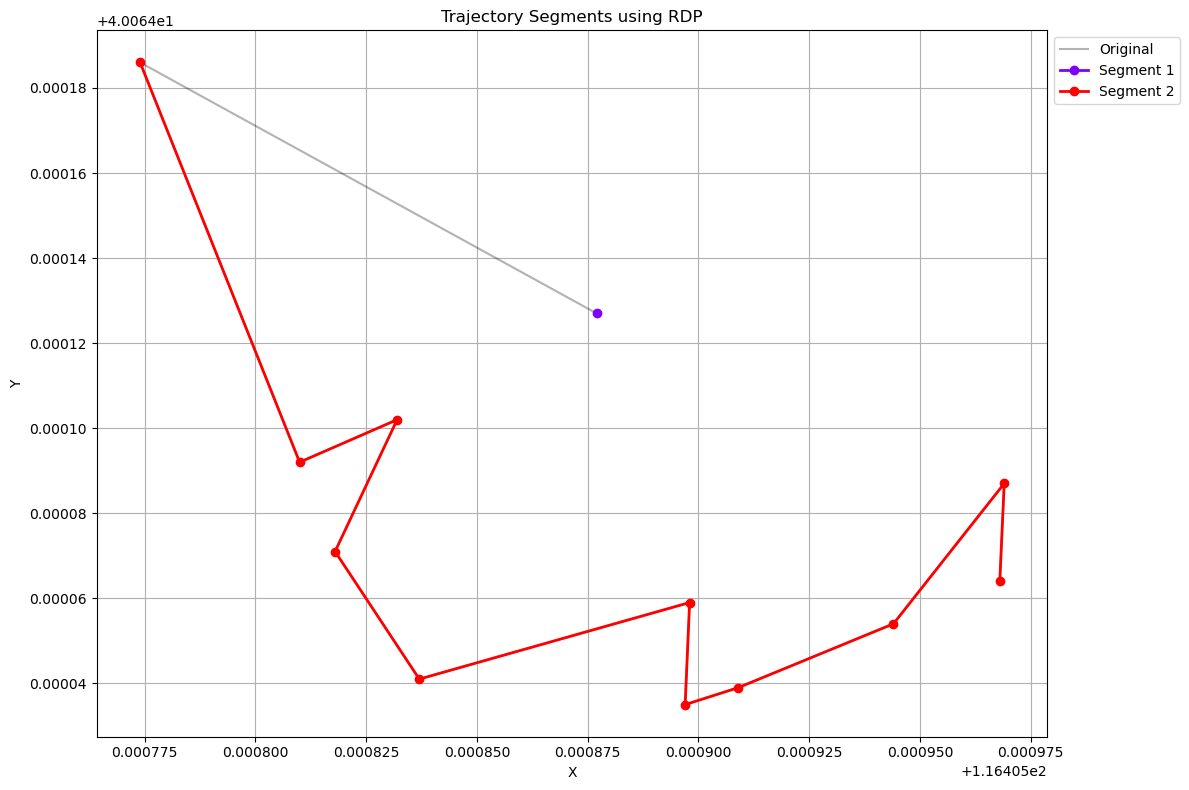

In [11]:
# Apply RDP segmentation
segments = rdp_segmentation(points, epsilon=0.01)
print(f"Number of segments: {len(segments)}")
print(segments)

# Plot the original trajectory and the segments
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, label="Original")

# Plot each segment with a different color
colors = plt.cm.rainbow(np.linspace(0, 1, len(segments)))
for i, segment in enumerate(segments):
    segment_x = [p[0] for p in segment]
    segment_y = [p[1] for p in segment]
    plt.plot(
        segment_x, segment_y, "-o", color=colors[i], linewidth=2, label=f"Segment {i+1}"
    )

plt.title("Trajectory Segments using RDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Perturb a Segment

scale: 0.000, preserve_endpoints: True


18:27:30 [DEBUG] residuals: tensor([[[ 0.0010,  0.0002]],

        [[ 0.0032,  0.0084]],

        [[-0.0028,  0.0044]],

        [[-0.0081,  0.0016]],

        [[-0.0119,  0.0014]],

        [[-0.0138,  0.0022]],

        [[-0.0143,  0.0031]],

        [[-0.0137,  0.0037]],

        [[-0.0121,  0.0040]],

        [[-0.0100,  0.0040]],

        [[-0.0073,  0.0038]]], device='cuda:0')


original: [Vector([116.405774,  40.064186]), Vector([116.40581 ,  40.064092]), Vector([116.405832,  40.064102]), Vector([116.405818,  40.064071]), Vector([116.405837,  40.064041]), Vector([116.405898,  40.064059]), Vector([116.405897,  40.064035]), Vector([116.405909,  40.064039]), Vector([116.405944,  40.064054]), Vector([116.405969,  40.064087]), Vector([116.405968,  40.064064])]
perturbed: [(np.float64(116.405774), np.float64(40.064186)), (np.float64(116.40581062302553), np.float64(40.064093638745405)), (np.float64(116.40583145418256), np.float64(40.06410285240066)), (np.float64(116.40581641290093), np.float64(40.06407131051465)), (np.float64(116.40583468694307), np.float64(40.06404126630403)), (np.float64(116.40589529956016), np.float64(40.064059421957964)), (np.float64(116.40589420352889), np.float64(40.06403559982909)), (np.float64(116.40590633510025), np.float64(40.06403972771303)), (np.float64(116.40594163586039), np.float64(40.06405478811439)), (np.float64(116.40596705835591),

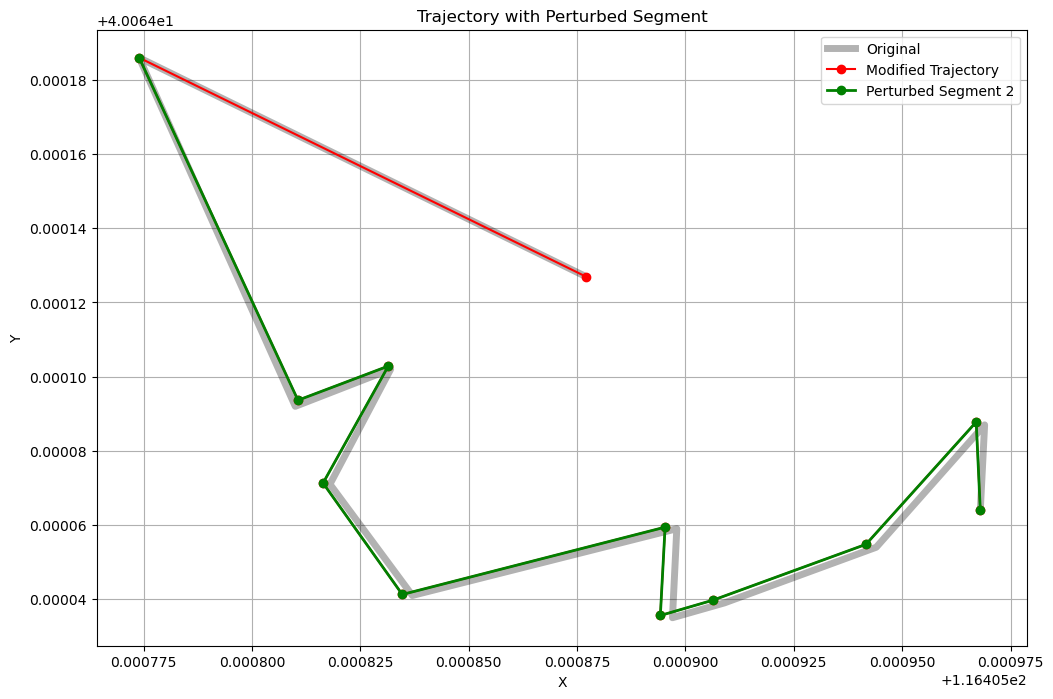

In [12]:
# Use GAN to apply to perturb one segment
segment_to_perturb = 1  # Choose which segment to perturb

scale = max(max(x) - min(x), max(y) - min(y))
preserve_endpoints = len(segments[segment_to_perturb]) > 2
print(f"scale: {scale:.3f}, preserve_endpoints: {preserve_endpoints}")

perturbed_segment = gan_perturbation(segments[segment_to_perturb], scale=scale, preserve_endpoints=preserve_endpoints)

print(f"original: {segments[segment_to_perturb]}")
print(f"perturbed: {perturbed_segment}")

# Visualize the perturbation
plt.figure(figsize=(12, 8))

# Plot original trajectory
plt.plot(x, y, "k-", alpha=0.3, lw=5, label="Original")

# Create a modified trajectory by replacing the perturbed segment
modified_segments = segments.copy()
modified_segments[segment_to_perturb] = perturbed_segment
modified_trajectory = []
for segment in modified_segments:
    modified_trajectory.extend(segment)

# Plot modified trajectory
modified_x = [p[0] for p in modified_trajectory]
modified_y = [p[1] for p in modified_trajectory]
plt.plot(modified_x, modified_y, "r-o", label="Modified Trajectory")

# Highlight the perturbed segment
perturbed_x = [p[0] for p in perturbed_segment]
perturbed_y = [p[1] for p in perturbed_segment]
plt.plot(
    perturbed_x,
    perturbed_y,
    "g-o",
    linewidth=2,
    label=f"Perturbed Segment {segment_to_perturb+1}",
)

plt.title("Trajectory with Perturbed Segment")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def visualize_perturbation(x, y, segments, segment_to_perturb, perturbed_segment):
    # Visualize the perturbation
    plt.figure(figsize=(12, 8))

    # Plot original trajectory
    plt.plot(x, y, "k-", alpha=0.3, lw=5, label="Original")

    # Create a modified trajectory by replacing the perturbed segment
    modified_segments = segments.copy()
    modified_segments[segment_to_perturb] = perturbed_segment
    modified_trajectory = []
    for segment in modified_segments:
        modified_trajectory.extend(segment)

    # Plot modified trajectory
    modified_x = [p[0] for p in modified_trajectory]
    modified_y = [p[1] for p in modified_trajectory]
    plt.plot(modified_x, modified_y, "r-o", label="Modified Trajectory")

    # Highlight the perturbed segment
    perturbed_x = [p[0] for p in perturbed_segment]
    perturbed_y = [p[1] for p in perturbed_segment]
    plt.plot(
        perturbed_x,
        perturbed_y,
        "g-o",
        linewidth=2,
        label=f"Perturbed Segment {segment_to_perturb+1}",
    )

    plt.title("Trajectory with Perturbed Segment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
# limit = 10

# for i in range(min(limit, len(test.trajs))):
#     points = test.trajs[i].r
#     x = [p[0] for p in points]
#     y = [p[1] for p in points]

#     segments = rdp_segmentation(points, epsilon=0.01)
    
#     segment_to_perturb = np.random.randint(0, len(segments))
#     scale = max(max(x) - min(x), max(y) - min(y))
#     preserve_endpoints = len(segments[segment_to_perturb]) > 2
#     perturbed_segment = gan_perturbation(segments[segment_to_perturb], scale=scale, preserve_endpoints=preserve_endpoints)

#     visualize_perturbation(x, y, segments, segment_to_perturb, perturbed_segment)

## Train Black-box Model

In [15]:
# Build and train the model
model = LSTMModel(random_state=SEED)

# Train the model on the train dataset (with fewer epochs for demo)
model.train(train, dataset, epochs=5, batch_size=64)

# Evaluate the model on the test dataset
evaluation = model.evaluate(test)
evaluation.show()

18:27:32 [WARNING] Custom seed provided for lstm model. This calls 'tf.keras.utils.set_random_seed' which sets a global random state on python, numpy and tensorflow.


Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 928ms/step - accuracy: 0.4727 - loss: 1.6269
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 944ms/step - accuracy: 0.5036 - loss: 1.4299
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 980ms/step - accuracy: 0.5063 - loss: 1.3977
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 997ms/step - accuracy: 0.5109 - loss: 1.3780
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 964ms/step - accuracy: 0.5076 - loss: 1.3710
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

General statistics:

Accuracy: 0.500
F1-score: 0.071
Mean precision: 0.150
Mean recall: 0.102

Confusion matrix:

airplane  bike      boat      bus       car       run       subway    taxi      train     walk      precision 
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       
0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0

## Run TrajectoryManipulator and get fidelity metrics

In [20]:
import logging
logging.disable(logging.DEBUG)

In [48]:
n_explainable = 0
precision = 0  # total per-trajectory precision

for traj in test.trajs:
    points = traj.r

    trajectory_explainer = TrajectoryManipulator(points, rdp_segmentation, gaussian_perturbation, model)

    y_eval_sorted = trajectory_explainer.get_Y_eval_sorted()
    original_pred = trajectory_explainer.get_Y()

    count = 0  # running count of segments that change classification when perturbed
    precision_x = 0
    for i, pred in enumerate(y_eval_sorted):
        # Check if predictions differ
        val = 0 if np.allclose(pred, original_pred) else 1
        if val == 1:
            count += 1
        precision_x += val * (count / (i+1))
        # if not np.allclose(pred, original_pred):  # Check if predictions differ
        #     count += 1
        #     precision_x += count / (i+1)

    if count > 0:
        n_explainable += 1
        precision_x /= count
        precision += precision_x

precision /= len(test.trajs)
recall = n_explainable / len(test.trajs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━

In [49]:
h_mean = np.nan if recall == 0 else (2 * precision * recall) / (precision + recall)

In [50]:
print(f"Final Metrics:\nRecall {recall:.3f}\nPrecision {precision:.3f}\nH-Mean {h_mean:.3f}")

Final Metrics:
Recall 0.000
Precision 0.000
H-Mean nan


In [51]:
test_precision = 1.0
test_h_mean = (2 * test_precision * recall) / (test_precision + recall)
print(f"Final Metrics:\nRecall {recall:.3f}\nPrecision {test_precision:.3f}\nH-Mean {test_h_mean:.3f}")

Final Metrics:
Recall 0.000
Precision 1.000
H-Mean 0.000
